In [1]:
!pip install -q rasterstats
!pip install -q odc-stac -U

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterstats
import rioxarray as rxr
import rasterio
import adlfs
import contextily as ctx
from tqdm import tqdm
from pathlib import Path


In [3]:
# from dask.distributed import Client, LocalCluster
# cluster = LocalCluster(processes=False, n_workers=4, local_directory='/tmp')
# client = Client(cluster)
# client

In [4]:
import dask_gateway
cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.adapt(minimum=10, maximum=100)
print(client.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.6f9e919ae4e84cd4acec1859a4297c5c/status


In [5]:
gf = gpd.read_file('https://raw.githubusercontent.com/scottyhq/snotel/967b0071f3716118bfcae866c740cffb51fbb5f5/snotel-sites.geojson')

In [6]:
gf

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,mgrs,timeseries,geometry
0,301_CA_SNTL,Adin Mtn,1886.712036,41.235828,-120.791924,Modoc,California,1983-10-01 00:00:00,2100-01-01,True,10TFL,True,POINT (-120.79192 41.23583)
1,907_UT_SNTL,Agua Canyon,2712.719971,37.522171,-112.271179,Kane,Utah,1994-10-01 00:00:00,2100-01-01,True,12SUG,True,POINT (-112.27118 37.52217)
2,916_MT_SNTL,Albro Lake,2529.840088,45.597229,-111.959023,Madison,Montana,1996-09-01 00:00:00,2100-01-01,True,12TVR,True,POINT (-111.95902 45.59723)
3,1267_AK_SNTL,Alexander Lake,48.768002,61.749668,-150.889664,Matanuska-Susitna,Alaska,2014-08-28 00:00:00,2100-01-01,True,05VPJ,True,POINT (-150.88966 61.74967)
4,908_WA_SNTL,Alpine Meadows,1066.800049,47.779572,-121.698471,King,Washington,1994-09-01 00:00:00,2100-01-01,True,10TET,True,POINT (-121.69847 47.77957)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,877_AZ_SNTL,Workman Creek,2103.120117,33.812420,-110.917732,Gila,Arizona,1938-12-01 00:00:00,2100-01-01,True,12SWC,True,POINT (-110.91773 33.81242)
926,1228_UT_SNTL,Wrigley Creek,2842.869629,39.132332,-111.356850,Sanpete,Utah,2012-10-01 00:00:00,2100-01-01,True,12SVJ,True,POINT (-111.35685 39.13233)
927,1197_UT_SNTL,Yankee Reservoir,2649.321533,37.747971,-112.774948,Iron,Utah,2012-10-01 00:00:00,2100-01-01,True,12SUG,True,POINT (-112.77495 37.74797)
928,878_WY_SNTL,Younts Peak,2545.080078,43.932251,-109.817749,Park,Wyoming,1979-10-01 00:00:00,2100-01-01,True,12TWP,True,POINT (-109.81775 43.93225)


In [7]:
snotel_gf = gf[gf.isActive==True]
snotel_gf = snotel_gf[(snotel_gf.beginDate<'2015-01-01') & (snotel_gf.endDate>'2022-01-01')]
snotel_gf = snotel_gf[snotel_gf.state!='Alaska']

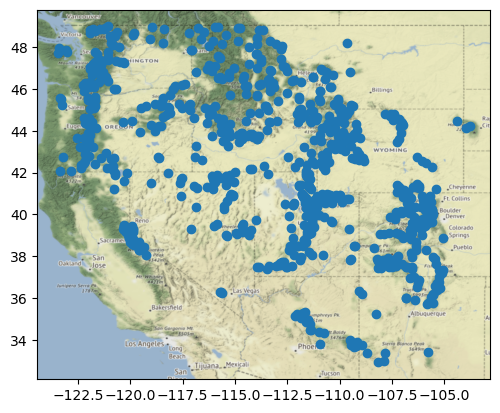

In [8]:
f,ax=plt.subplots()
snotel_gf.plot(ax=ax)
ctx.add_basemap(ax=ax, crs=snotel_gf.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

In [9]:
#years = [2015,2016,2017,2018,2019,2020,2021,2022]
#years = [2016,2017,2018,2019,2020,2021,2022]
years = [2017,2018,2019,2020,2021,2022]
max_swe_years = [f'max_swe_{year}' for year in years]

In [10]:
#for i,row in tqdm(snotel_gf.iterrows()):
#    try:
#        snotel_data = pd.read_parquet(f'https://github.com/scottyhq/snotel/raw/main/parquet/{row.code}.parquet').loc[slice(f'{years[0]}-01-01',f'{years[-1]}-12-31')]
#        snotel_data = snotel_data[(snotel_data.index.month>1)&(snotel_data.index.month<10)]
#        dates = snotel_data.groupby(snotel_data.index.year).idxmax()['WTEQ']
    #print(dates)
#        if len(dates)==len(years):
#            snotel_gf.loc[i,max_swe_years] = dates.values
#    except:
#        pass
    #date_index = []
    #for date in dates.index.values:
    #    date_index.append(f'max_swe_{date}')
    #snotel_gf = snotel_gf.loc[i,iter(date_index)] = dates.loc[2015:2022]

In [11]:
%%time
my_file = Path("snotel_gf.geojson")
if my_file.is_file():
    snotel_gf = gpd.read_file('snotel_gf.geojson')
else:
    for i,row in tqdm(snotel_gf.iterrows()):
        try:
            snotel_data = pd.read_parquet(f'https://github.com/scottyhq/snotel/raw/main/parquet/{row.code}.parquet').loc[slice(f'{years[0]}-01-01',f'{years[-1]}-12-31')]
            snotel_data = snotel_data[(snotel_data.index.month>1)&(snotel_data.index.month<10)]

            dates = snotel_data.groupby(snotel_data.index.year).idxmax()['WTEQ']
            dates = dates[dates.notna()]
        #print(dates)
            #if len(dates)==len(years):
            #    snotel_gf.loc[i,max_swe_years] = dates.values
            for year in [date for date in dates.index]:
                snotel_gf.loc[i,f'max_swe_{year}'] = int(dates.dt.dayofyear[year])
        except:
            pass
        
        #for year in years:
        #    snotel_gf[f'max_swe_{year}'] = pd.to_datetime(snotel_gf[f'max_swe_{year}']).dt.dayofyear
            
    snotel_gf.to_file("snotel_gf.geojson", driver='GeoJSON')

796it [05:58,  2.22it/s]


CPU times: user 36.2 s, sys: 5.34 s, total: 41.6 s
Wall time: 5min 58s


In [ ]:
snotel_gf

In [12]:
snotel_gf = snotel_gf.to_crs('EPSG:32611')

In [13]:
buffer = 2000 # at 1000m with 2015 excluded, medians of medians at 38 days, with 500m 34 days, with 200m 36.25 days, with 2000m 37 days
# 27 days new method 500m method, 22.0 with 1000m new new method, 23.5 with 500m new new method, 22.0 with 2000m
snotel_gf = gpd.GeoDataFrame(snotel_gf,geometry=snotel_gf.buffer(buffer))

In [14]:
sas_token = 'se=2023-03-06T02%3A45Z&sp=racwdl&sv=2018-11-09&sr=c&skoid=b4d39ccb-ca9c-4e9d-a183-5e0f3ba3e609&sktid=f6b6dd5b-f02f-441a-99a0-162ac5060bd2&skt=2023-02-27T23%3A04%3A11Z&ske=2023-03-06T02%3A45%3A00Z&sks=b&skv=2018-11-09&sig=foscauRfnuTGG//8wOeOu%2BFBoa5IuYUDnYIrqu%2BBzuQ%3D'
tile_names = [tile[-5:] for tile in adlfs.AzureBlobFileSystem(account_name="snowmelt", credential=sas_token, anon=False).ls('snowmelt/eric/MGRS/')]

In [15]:
stats=['count', 'min', 'max', 'mean', 'median', 'std']

In [16]:
resolution = 80

In [17]:
for i,row in tqdm(snotel_gf.iterrows()):
    if row.mgrs in tile_names:
        #print(f'{row.code} in MGRS square {row.mgrs}')
        for year in years:
            try:
                raster = rasterio.open(f"https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/{row.mgrs}/runoff_onset_{row.mgrs}_{year}_median_{resolution}m.tif")
                snotel_row_proj = snotel_gf[snotel_gf.index==i].to_crs(raster.crs)
                statistics = rasterstats.zonal_stats(snotel_row_proj, raster.read(1), affine=raster.transform, stats=stats, nodata=-32768)
                snotel_gf.loc[i,f'sar_runoff_{year}'] = statistics[0]['median']
                if year == 2022:
                    snotel_gf.loc[i,f'sar_runoff_pixel_count'] = statistics[0]['count']
            except:
            #print(f'Error with tile {row.mgrs} for year {year}')
                pass


341it [04:11,  1.23it/s]2023-02-28 21:10:38,292 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:997)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handle

In [18]:
for year in years:
        snotel_gf[f'offset_{year}'] = snotel_gf[f'max_swe_{year}'] - snotel_gf[f'sar_runoff_{year}']

In [19]:
snotel_gf['median_offset'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('offset')]].abs().median(axis=1)
snotel_gf['mean_offset'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('offset')]].abs().mean(axis=1)

In [20]:
snotel_gf.sort_values('mean_offset')#.head(20)
#snotel_gf.sort_values('median_offset').head(20)

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,...,sar_runoff_2022,sar_runoff_pixel_count,offset_2017,offset_2018,offset_2019,offset_2020,offset_2021,offset_2022,median_offset,mean_offset
608,673_WY_SNTL,Old Battle,3048.000000,41.153969,-106.969368,Carbon,Wyoming,1962-09-01 00:00:00,2100-01-01,True,...,125.0,167.0,8.0,1.0,21.0,-2.0,0.0,0.0,1.5,5.333333
866,838_CO_SNTL,University Camp,3139.439941,40.032791,-105.576149,Boulder,Colorado,1978-10-01 00:00:00,2100-01-01,True,...,139.0,126.0,0.0,3.0,0.0,-14.5,1.0,-14.0,2.0,5.416667
390,541_CA_SNTL,Independence Lake,2541.422363,39.427521,-120.313423,Nevada,California,1978-10-01 00:00:00,2100-01-01,True,...,104.0,98.0,12.0,1.0,-5.0,2.0,-7.0,11.0,6.0,6.333333
639,1263_WA_SNTL,Pinto Rock,1353.312012,46.323181,-121.942192,Skamania,Washington,2014-10-01 00:00:00,2100-01-01,True,...,117.0,45.0,10.0,15.0,2.0,-3.0,-6.0,3.0,4.5,6.500000
37,1061_CO_SNTL,Bear River,2767.583984,40.061531,-107.009552,Routt,Colorado,2004-10-01 00:00:00,2100-01-01,True,...,96.0,413.0,11.0,3.0,-6.0,9.0,1.0,10.0,7.5,6.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,864_UT_SNTL,White River #1,2633.776855,39.964500,-110.988449,Wasatch,Utah,1978-10-01 00:00:00,2100-01-01,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
911,1213_NV_SNTL,White River Nv,2245.461670,38.945572,-115.379219,White Pine,Nevada,2011-12-23 09:00:00,2100-01-01,True,...,119.0,953.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
914,866_AZ_SNTL,Wildcat,2392.679932,33.758350,-109.479729,Greenlee,Arizona,1983-10-01 00:00:00,2100-01-01,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
920,872_WY_SNTL,Windy Peak,2407.919922,42.280201,-105.578163,Albany,Wyoming,1979-10-01 00:00:00,2100-01-01,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


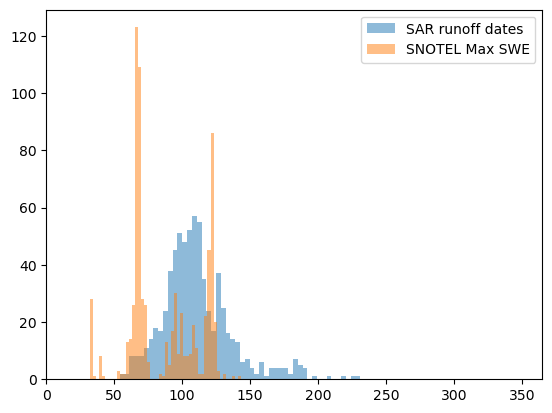

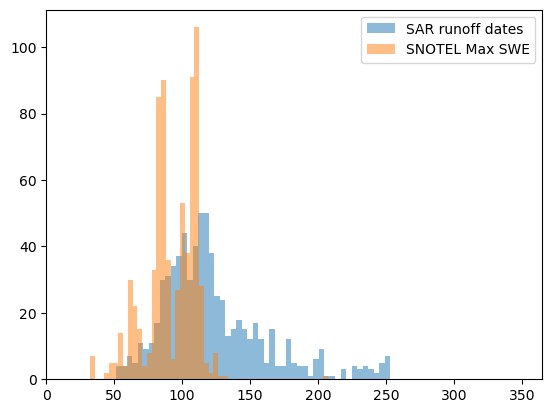

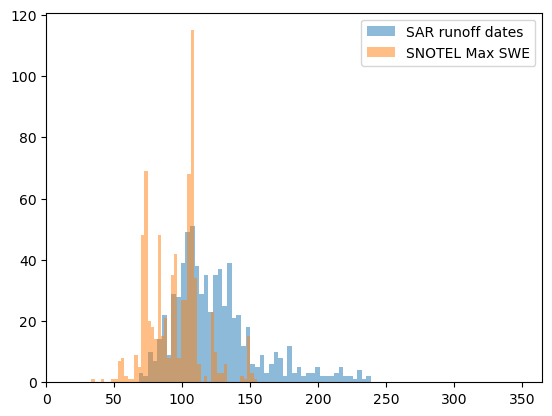

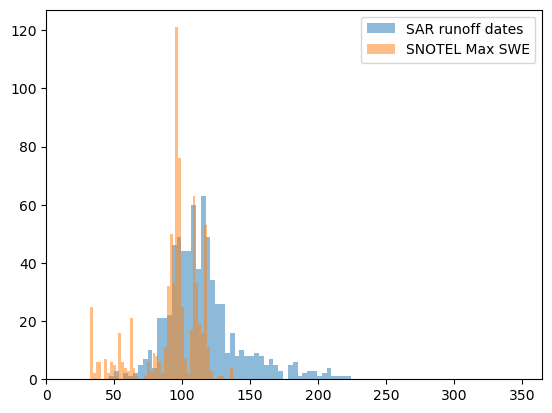

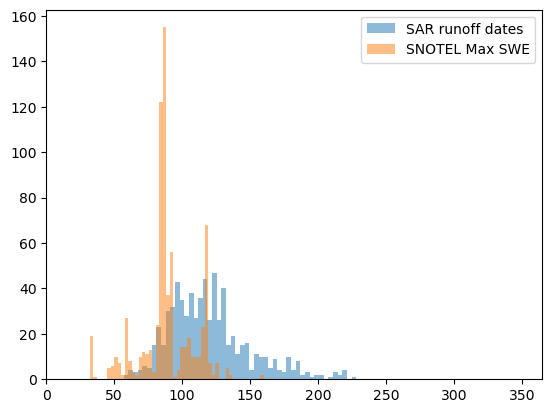

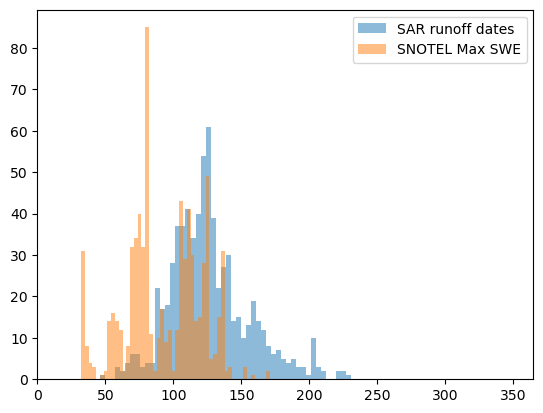

In [21]:
#snotel_offsets = np.array()
for year in years:
        #np.append(snotel_offsets,snotel_gf[f'offset_{year}'])
        f,ax=plt.subplots()
        ax.hist(snotel_gf[f'sar_runoff_{year}'],bins=50,alpha=0.5,label='SAR runoff dates')
        ax.hist(snotel_gf[f'max_swe_{year}'],bins=50,alpha=0.5,label='SNOTEL Max SWE')
        ax.legend()
        ax.set_xlim([0,365])
        # make a histogram out of this
#f,ax=plt.subplots(2,1,figsize=(10,10))
#ax.hist(snotel_offsets)

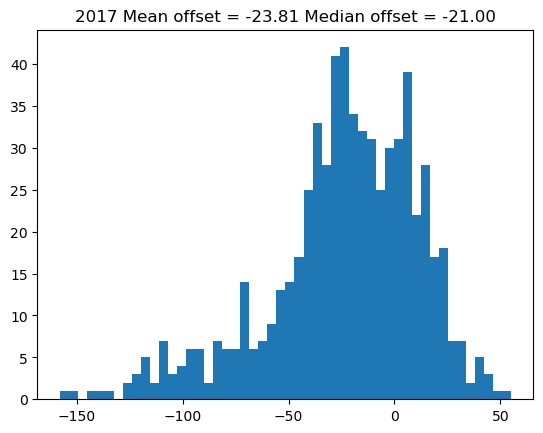

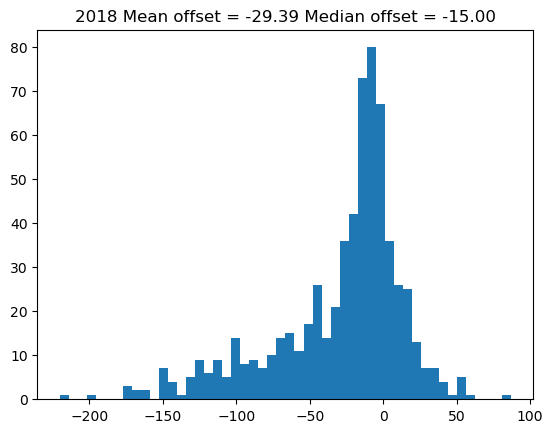

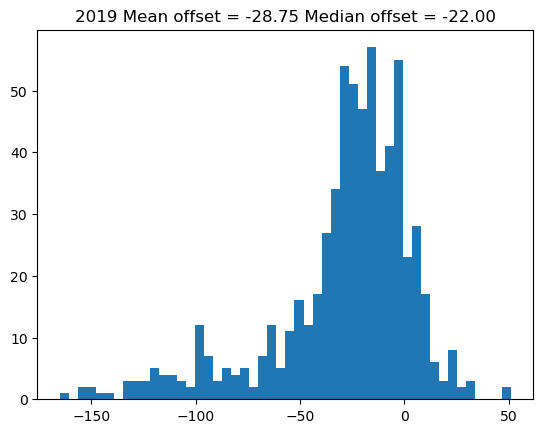

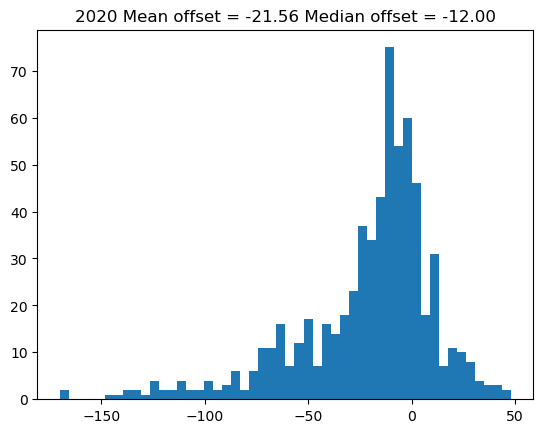

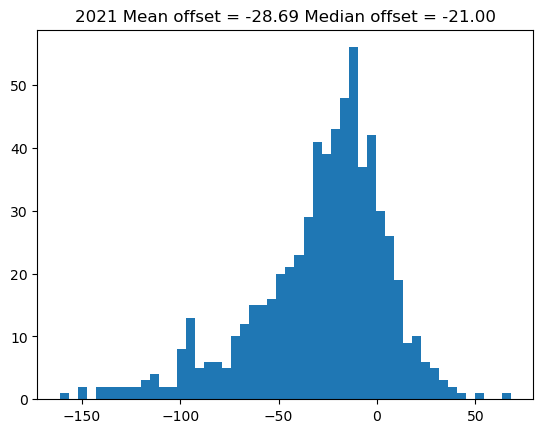

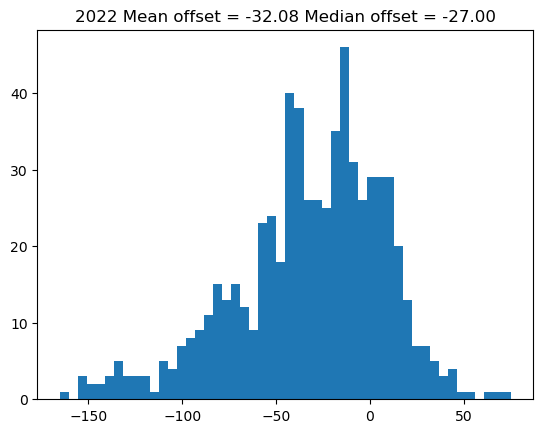

In [22]:
for year in years:
        f,ax=plt.subplots()
        ax.hist(snotel_gf[f'offset_{year}'],bins=50)
        mean = snotel_gf[f'offset_{year}'].mean()
        median = snotel_gf[f'offset_{year}'].median()
        ax.set_title(f'{year} Mean offset = {mean:.2f} Median offset = {median:.2f}')


Text(0.5, 0, 'Offset [Days]')

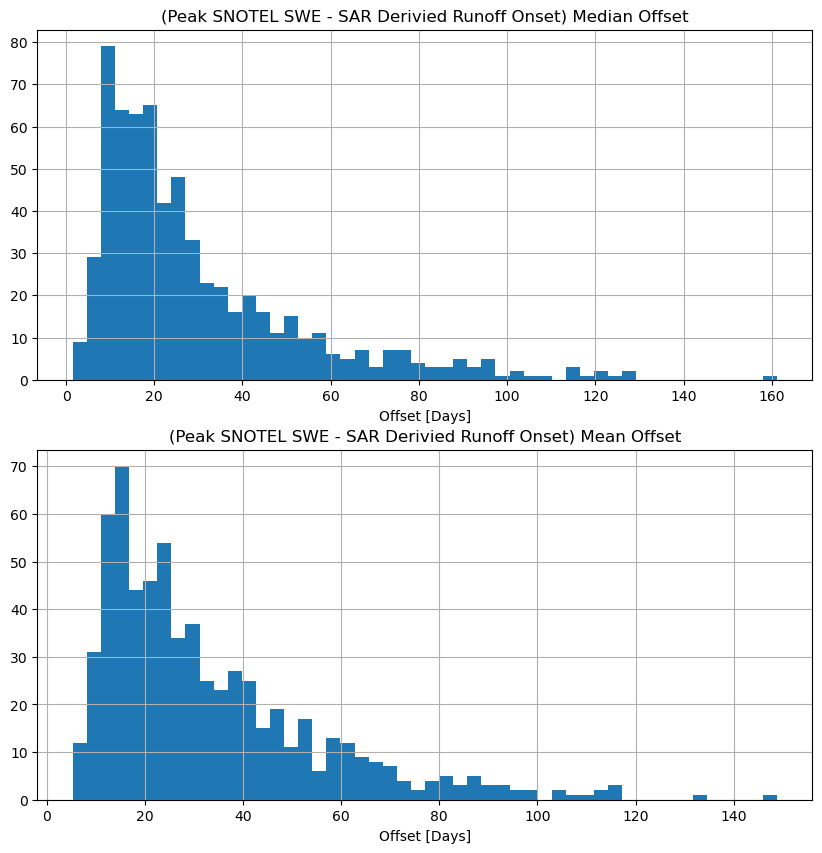

In [23]:
f,ax=plt.subplots(2,1,figsize=(10,10))
snotel_gf['median_offset'].hist(bins=50,ax=ax[0])
snotel_gf['mean_offset'].hist(bins=50,ax=ax[1])
ax[0].set_title('(Peak SNOTEL SWE - SAR Derivied Runoff Onset) Median Offset')
ax[1].set_title('(Peak SNOTEL SWE - SAR Derivied Runoff Onset) Mean Offset')
ax[0].set_xlabel('Offset [Days]')
ax[1].set_xlabel('Offset [Days]')

In [24]:
snotel_gf['median_offset'].median()
# 25 all years
# 22.5 2017 on

22.0

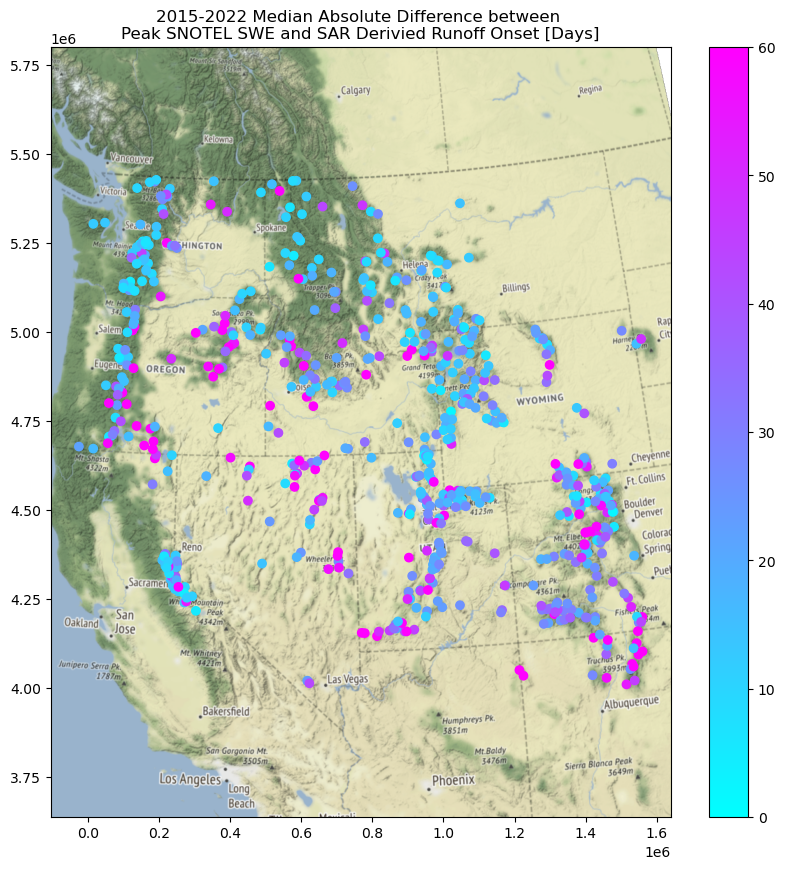

In [25]:
f,ax=plt.subplots(figsize=(10,10))
snotel_gf_projected = gpd.GeoDataFrame(snotel_gf,geometry=gf.geometry).to_crs('EPSG:32611')
snotel_gf_projected.plot(column='median_offset',ax=ax,legend=True,cmap='cool',vmin=0,vmax=60)
ax.axis('equal')
ax.set_title('2015-2022 Median Absolute Difference between \nPeak SNOTEL SWE and SAR Derivied Runoff Onset [Days]')
ctx.add_basemap(ax=ax, crs=snotel_gf_projected.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

In [26]:
tooltip_list = ['code','name','elevation_m']
for year in years:
    tooltip_list.append(f'offset_{year}')                
tooltip_list.extend(['median_offset','mean_offset','sar_runoff_pixel_count'])

In [27]:
snotel_gf_projected = snotel_gf_projected.drop(['beginDate','endDate','isActive'],axis=1)

In [28]:
snotel_gf_projected.explore(column='median_offset',cmap='cool',tooltip=tooltip_list,vmin=0,vmax=60)

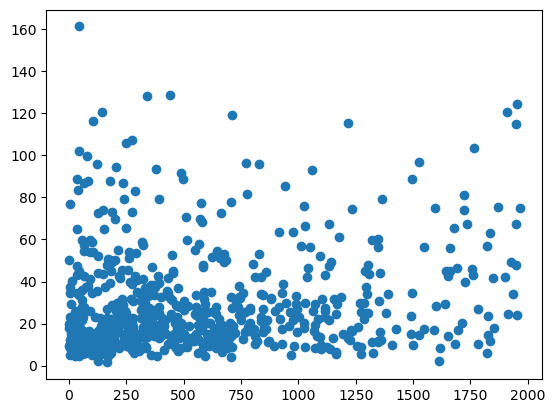

In [29]:
f,ax=plt.subplots()
ax.scatter(snotel_gf_projected['sar_runoff_pixel_count'],snotel_gf_projected['median_offset'])
#ax.set_xlim([0,10])

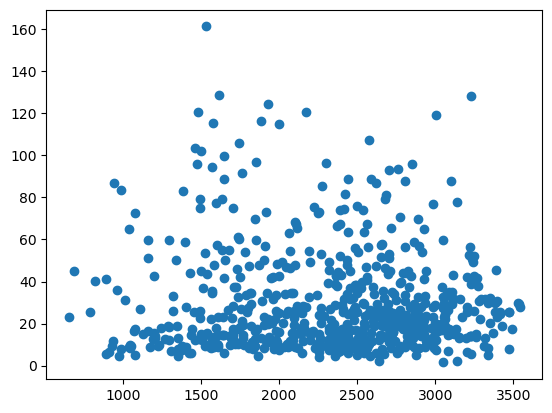

In [30]:
f,ax=plt.subplots()
ax.scatter(snotel_gf_projected['elevation_m'],snotel_gf_projected['median_offset'])

In [31]:
snotel_gf_projected.corr()

,elevation_m,latitude,longitude,timeseries,max_swe_2017,max_swe_2018,max_swe_2019,max_swe_2020,max_swe_2021,max_swe_2022,...,sar_runoff_2022,sar_runoff_pixel_count,offset_2017,offset_2018,offset_2019,offset_2020,offset_2021,offset_2022,median_offset,mean_offset
elevation_m,1.000000,-0.685418,0.798646,0.056699,0.186631,0.098928,0.449694,0.315958,0.253791,0.191599,...,0.033798,0.213441,0.086510,0.051196,-0.017228,0.048608,-0.002276,0.089712,-0.068170,-0.088532
latitude,-0.685418,1.000000,-0.493469,-0.009055,0.340355,0.484668,0.131157,0.258015,0.327532,0.366084,...,0.011862,-0.233268,0.215476,0.162719,0.135671,0.179046,0.166739,0.227970,-0.219975,-0.212867
longitude,0.798646,-0.493469,1.000000,0.058555,0.000046,0.072318,0.279560,0.240815,0.207681,0.178817,...,0.065843,0.075947,-0.033309,0.018160,-0.117820,-0.041979,-0.045863,0.081127,0.023848,0.011232
timeseries,0.056699,-0.009055,0.058555,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.049531,-0.091800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_swe_2017,0.186631,0.340355,0.000046,NaN,1.000000,0.696466,0.712136,0.644404,0.695712,0.710321,...,-0.028632,-0.046976,0.694069,0.356295,0.317821,0.356537,0.320676,0.493570,-0.507316,-0.533537
max_swe_2018,0.098928,0.484668,0.072318,NaN,0.696466,1.000000,0.646359,0.722737,0.736403,0.737777,...,-0.064932,-0.131486,0.518146,0.496718,0.277295,0.450884,0.355360,0.541253,-0.549540,-0.563492
max_swe_2019,0.449694,0.131157,0.279560,NaN,0.712136,0.646359,1.000000,0.679325,0.705482,0.673777,...,-0.016945,0.020287,0.468271,0.333401,0.414117,0.343240,0.338579,0.455775,-0.484909,-0.507028
max_swe_2020,0.315958,0.258015,0.240815,NaN,0.644404,0.722737,0.679325,1.000000,0.750711,0.706685,...,-0.073742,-0.113785,0.483745,0.367251,0.233626,0.637807,0.364901,0.527308,-0.580180,-0.581607
max_swe_2021,0.253791,0.327532,0.207681,NaN,0.695712,0.736403,0.705482,0.750711,1.000000,0.755746,...,0.001120,-0.085251,0.478605,0.391619,0.269494,0.398867,0.524880,0.515870,-0.487205,-0.511000
max_swe_2022,0.191599,0.366084,0.178817,NaN,0.710321,0.737777,0.673777,0.706685,0.755746,1.000000,...,-0.003459,-0.109635,0.498543,0.366649,0.242627,0.383546,0.337516,0.692501,-0.495560,-0.509078


In [32]:
snotel_gf_projected.describe()

,elevation_m,latitude,longitude,max_swe_2017,max_swe_2018,max_swe_2019,max_swe_2020,max_swe_2021,max_swe_2022,sar_runoff_2017,...,sar_runoff_2022,sar_runoff_pixel_count,offset_2017,offset_2018,offset_2019,offset_2020,offset_2021,offset_2022,median_offset,mean_offset
count,796.000000,796.000000,796.000000,729.000000,727.000000,729.000000,728.000000,730.000000,730.000000,704.000000,...,699.000000,707.000000,646.000000,645.000000,647.000000,646.000000,647.000000,643.000000,649.000000,649.000000
mean,2300.085130,42.231755,-113.214811,85.962963,91.997249,94.729767,92.502747,88.702740,92.523288,110.921875,...,126.257511,599.046676,-23.808050,-29.393023,-28.745750,-21.555728,-28.688563,-32.083981,29.877504,33.092707
std,642.544918,3.651480,5.231593,26.139839,18.785141,19.481598,21.953182,20.180342,28.214058,26.200268,...,29.396951,518.080926,35.703673,44.717950,33.894903,33.712866,34.234960,39.801013,24.290118,22.587136
min,128.016006,32.924011,-123.457474,32.000000,32.000000,33.000000,32.000000,32.000000,32.000000,54.000000,...,46.000000,0.000000,-158.000000,-220.000000,-165.000000,-170.000000,-161.000000,-165.000000,1.500000,5.333333
25%,1829.562012,39.406603,-117.095798,67.000000,83.000000,78.000000,90.000000,84.000000,74.000000,95.000000,...,108.000000,180.000000,-39.000000,-48.000000,-38.000000,-34.000000,-45.500000,-54.000000,13.250000,16.166667
50%,2400.299927,42.135935,-111.957687,72.000000,94.000000,95.000000,96.000000,86.000000,91.000000,108.000000,...,123.000000,458.000000,-21.000000,-15.000000,-22.000000,-12.000000,-21.000000,-27.000000,22.000000,26.333333
75%,2785.033691,45.068324,-109.369423,114.000000,108.000000,107.000000,108.000000,101.000000,115.000000,123.000000,...,140.000000,906.000000,2.000000,-3.000000,-7.000000,-1.000000,-6.000000,-4.000000,38.000000,42.500000
max,3541.775879,48.980751,-103.787582,143.000000,207.000000,155.000000,137.000000,160.000000,171.000000,231.000000,...,231.000000,1965.000000,55.000000,87.000000,51.000000,48.000000,68.000000,75.000000,161.250000,148.833333
